# Kepler-22 b

In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

planets = Table.read('../../planets2.txt', format='csv', comment='#')
K22b = planets[planets['pl_name'] == 'Kepler-22 b'][0]
print(K22b['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

  pl_name   sy_jmag st_teff pl_rade
----------- ------- ------- -------
Kepler-22 b  10.523  5642.0    2.17


### Compute the probabilistic mass using Kipping & Chen: https://iopscience.iop.org/article/10.3847/1538-4357/834/1/17

In [8]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=K22b['pl_rade'], std=K22b['pl_radeerr1'], unit='Earth', sample_size=1000, grid_size=200)
print(res)

(5.942990350788005, 4.05955554469579, 2.411975879211719)


### Compute the hill sphere

In [10]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * mj_ms/(3*ms)) ** (1./3.)

a = 0.859 - 0.017, 0.849, 0.849 + 0.018
e = 0.05, 0.0, 0.05
likely_hill = hill(res[0], K22b['st_mass'], a[0], e[0])
pessimistic_hill = hill(res[0]-res[1], K22b['st_mass']-0.02, a[1], e[2])
optimistic_hill = hill(res[0]+res[1], K22b['st_mass']+0.02, a[2], e[1])
print(likely_hill, " ", pessimistic_hill, " ", optimistic_hill)

0.0999159181230487   0.06916634832370362   0.12794758898872635


### Look at the light curve to assess variability and rotation:

In [11]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile('Kepler-22', mission='Kepler').download_all()
lcfs_sc = lk.search_lightcurvefile('Kepler-22', mission='Kepler', cadence='short').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc_sc = lcfs_sc.PDCSAP_FLUX.stitch()

0.0005056105
[0.98077427 0.98062995 0.98091794 ... 1.96163564 2.94259743 0.98096178]


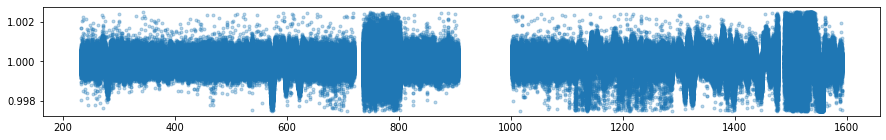

In [12]:
clipped_lc_sc = lc_sc.remove_outliers(sigma=5)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc_sc.time, clipped_lc_sc.flux, '.',alpha=0.3)
print(np.std(clipped_lc_sc.flux))
print(np.diff(clipped_lc_sc.time)*60*24)

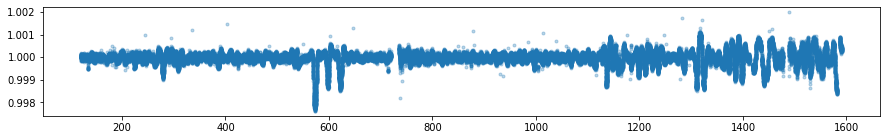

In [13]:
clipped_lc = lc.remove_outliers(sigma=10)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.', alpha=0.3)

### Compute the power spectrum of the combined Kepler light curve

<ipython-input-19-82152cde3fc3>:20: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pl.annotate(s='approximate Kepler noise', xy=(1e-3, 200))
<ipython-input-19-82152cde3fc3>:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 82))


Text(0.5, 0, 'frequency (1/days)')

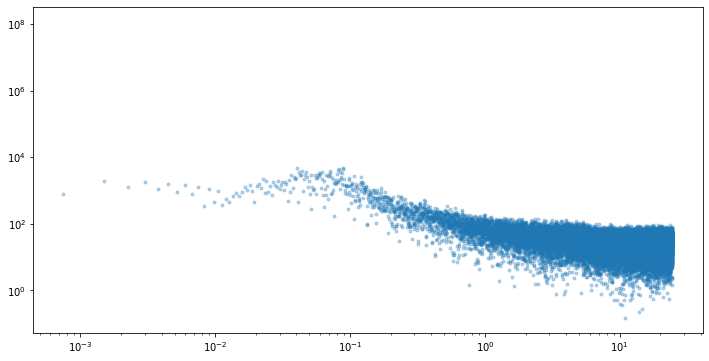

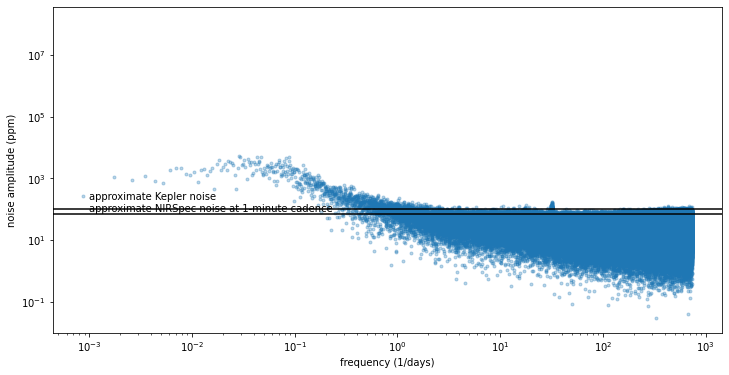

In [19]:
f = np.fft.rfftfreq(len(clipped_lc.flux), clipped_lc.time[1] - clipped_lc.time[0])
fft = np.fft.rfft(clipped_lc.flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(clipped_lc.time)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

f_sc = np.fft.rfftfreq(len(clipped_lc_sc.flux), clipped_lc_sc.time[1] - clipped_lc_sc.time[0])
fft_sc = np.fft.rfft(clipped_lc_sc.flux)
fft_sc = fft_sc*np.conj(fft_sc)
powerfft_sc = fft_sc.real / len(clipped_lc_sc.time)**2
ampfft_sc = np.sqrt(powerfft_sc * (60 * 60 * 24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, ampfft, '.', alpha=0.3)
pl.figure(figsize=(12, 6))
pl.loglog(f_sc, ampfft_sc, '.', alpha=0.3)

pl.axhline(100, color='k')
pl.axhline(72, color='k')
pl.annotate(s='approximate Kepler noise', xy=(1e-3, 200))
pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 82))

pl.ylabel("noise amplitude (ppm)")
pl.xlabel("frequency (1/days)")

#pl.ylim(1, 1e4)

In [20]:
# approximate white noise of 200 ppm converted to S0 hyperparam
ppm = 100
S0 = (((ppm * 1e-6 ) ** 2) / 50) / 10
print('Maximum S0 value for {0} ppm white noise is {1}'.format(ppm, S0))

Maximum S0 value for 100 ppm white noise is 2e-11


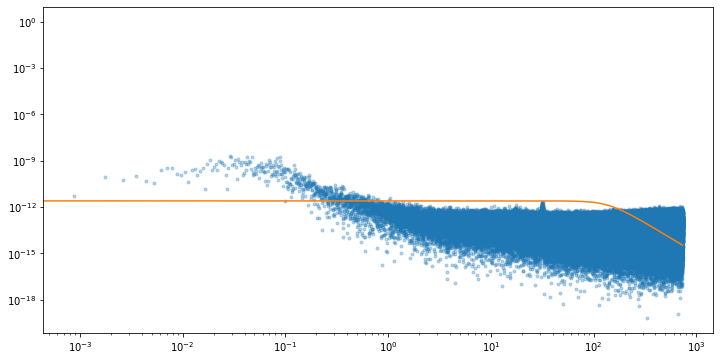

In [21]:
import celerite2
from celerite2 import terms

pl.figure(figsize=(12, 6))
pl.loglog(f_sc, powerfft_sc, '.', alpha=0.3)

# just making this up but it looks good 
term = terms.SHOTerm(S0=S0, w0=886, Q=1/np.sqrt(2))

psd = term.get_psd(2*np.pi*f_sc)
psd /= (2*np.pi)

pl.loglog(f_sc, psd)

In [22]:
(1 / (2*886*5)) * 60 * 60 * 24

9.751693002257337

### Let's say $8\times 10^{-11}$ is an upper limit on $S_0$ then and realize some noise!

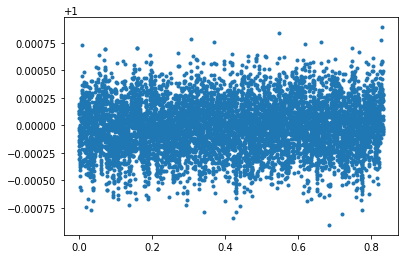

In [23]:
gp = celerite2.GaussianProcess(term, mean=0.0)

wn = lambda ppm: np.random.randn(len(t)) * ppm * 1e-6

# one day
t_start = 0
t_end = 1 * (20/24)
n = np.int((t_end - t_start) / 0.00011)
t = np.linspace(t_start, t_end, n)
gp.compute(t, yerr = 0)

# A realization of the Kepler granulation component with no white noise 
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)
pl.plot(t, fk + wn(200), '.')

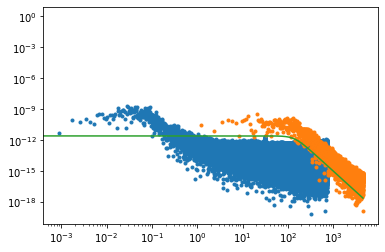

In [24]:
#fk += np.random.randn(len(fk)) * 65 * 1e-6
f = np.fft.rfftfreq(len(fk), t[1]-t[0])
fft = np.fft.rfft(fk)
fft = fft*np.conj(fft)
powerfft = fft.real / len(fk)**2

psd = term.get_psd(2*np.pi*f)
psd /= (2*np.pi)

pl.loglog(f_sc, powerfft_sc, '.')
pl.loglog(f, powerfft, '.')
pl.loglog(f, psd)